In [1]:
#!pip install pillow


In [2]:
from PIL import Image, ImageOps
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [7]:
def max_sizes(input_folder):
    max_width = 0
    max_height = 0
    # First, iterate through all images to find the maximum dimensions
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height
    return max_width, max_height

In [8]:
# Define the range of white color
def is_white_color(color, threshold=230):
    # Check if color is close to white within the given threshold
    return all(c >= threshold for c in color)


# Adjust threshold based on what is considered "close to white"
def crop_white_bottom_from_image(img, height_to_check=8, check_width=10, start_from=60, threshold=230):
    width, height = img.size
    # Define the region to check for white color
    box = (start_from, height - height_to_check, start_from + check_width, height)
    region = img.crop(box)
    # Convert the region to a NumPy array for easy processing
    region_np = np.array(region)
    # Check if all pixels in the region are close to white
    white_pixels = np.apply_along_axis(is_white_color, 1, region_np)
    
    if np.all(white_pixels):
        # Crop the bottom 16 pixels
        img = img.crop((0, 0, width, height - height_to_check - 8))
    return img


def padding_images(img,max_width,max_height):
    # Calculate padding required to center the image
    delta_width = max_width - img.width
    delta_height = max_height - img.height
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    # Add padding and create a new image with the desired size
    return ImageOps.expand(img, padding, fill=0)

def format_to_rgb(img):
    if img.mode != 'RGB':
        # Convert image to RGB
        img = img.convert('RGB')
    return img
    

In [10]:
def crop_white_bottom_add_padding_all_rgb(input_folder,output_folder):
    max_width, max_height = max_sizes(input_folder)

    # Create the new folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through each image in the source folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(input_folder, filename)
            with Image.open(file_path) as img:
                img = crop_white_bottom_from_image(img)
                img = padding_images(img,max_width,max_height)
                img = format_to_rgb(img)
                # Save the original image to the new folder
                new_file_path = os.path.join(output_folder, filename)
                img.save(new_file_path)
    print(output_folder, "Processing complete.")

In [11]:
# Path to the train folder and the new train folder
input_train_folder = '../data/train_features'
output_train_folder = '../data/new_train_features'

# Path to the test folder and the new test folder
input_test_folder = '../data/test_features'
output_test_folder = '../data/new_test_features'


crop_white_bottom_add_padding_all_rgb(input_train_folder,output_train_folder)
crop_white_bottom_add_padding_all_rgb(input_test_folder,output_test_folder)

../data/new_train_features Processing complete.
../data/new_test_features Processing complete.


Found 3956 validated image filenames.
Found 990 validated image filenames.


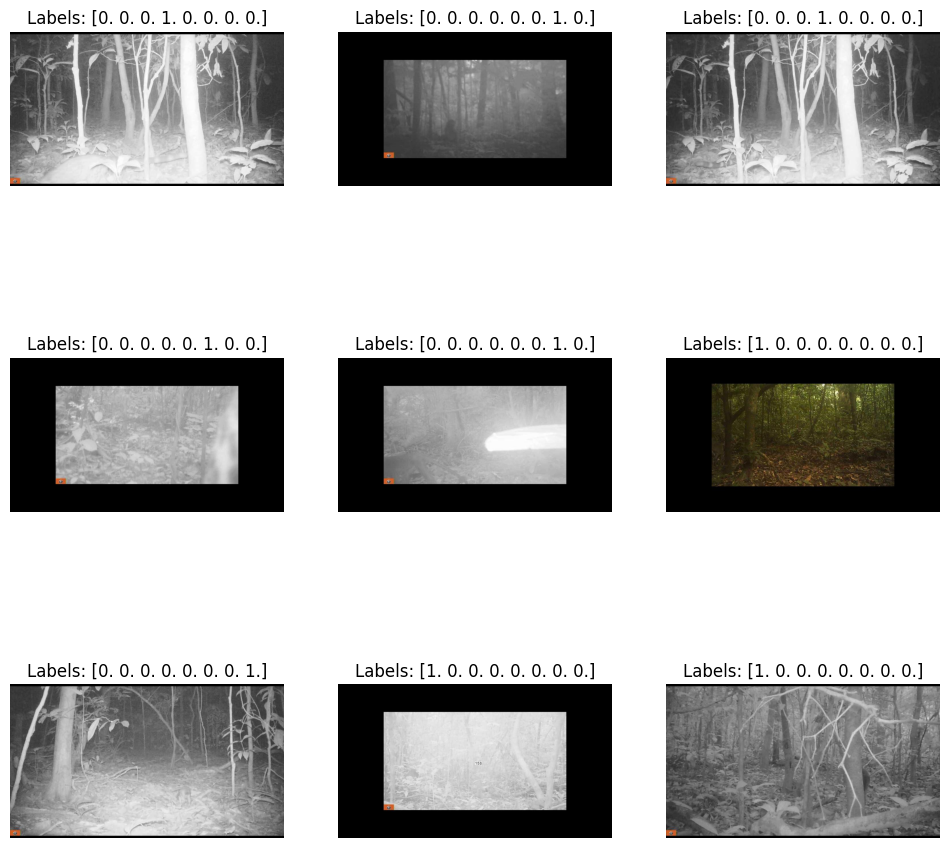

In [12]:
# Paths
dataset_folder = '../data/new_train_features'  # Path to the folder with images
labels_file = '../data/train_labels.csv'  # Path to the CSV file with labels
# Image parameters
img_width, img_height = max_sizes(dataset_folder)
#img_height = 128  # Set your image height
#img_width = 128   # Set your image width
batch_size = 32

# Load labels from CSV
df = pd.read_csv(labels_file)

frac = 0.3

df = df.sample(frac=frac, random_state=1)


# Add a full path to each image in the dataframe
df['id'] = df['id'].apply(lambda x: os.path.join(dataset_folder, x+'.jpg'))

# Perform stratified split based on the labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[df.columns[1:]])

# Data generator
datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]
# Create the training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='id',
    y_col=train_df.columns[1:],  # All columns except 'ID' are labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)
# Create the validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='id',
    y_col=val_df.columns[1:],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)



# Example: Display a batch of images and labels
images, labels = next(train_generator)  # Get a batch of images and labels
plt.figure(figsize=(12, 12))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Labels: {labels[i]}")
    plt.axis('off')
plt.show()

In [13]:
"""model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(df.columns) - 1, activation='softmax')  # Output layer for multi-label classification
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=1)#epochs=10"""

2024-08-27 17:09:29.236438: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-27 17:09:29.236461: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-27 17:09:29.236467: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-27 17:09:29.236865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-27 17:09:29.238299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-27 17:09:31.898980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  5/124 [>.............................] - ETA: 1:34:31 - loss: 92.6268 - accuracy: 0.1688